In [151]:
import os
import glob
import copy
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from PIL import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, balanced_accuracy_score, accuracy_score
import scipy

In [152]:
load_dotenv('test.env')
raw_dir = os.environ['RAW_DIR']
interim_dir = os.environ['INTERIM_DIR']

In [153]:
def medianmad_norm(arr_like):
    '''
    Normalize by median and MAD

    Modified version from the function made available by the professor
    '''
    np_arr = np.array(arr_like)
    median = np.median(np_arr)
    dev = np.abs(np_arr - median)
    mad = np.median(dev)
    norm = ((np_arr - median) / mad)
    return (norm,mad)

def tanh_modified_norm(arr_like):
    np_arr = np.array(arr_like)

    mean = np.mean(np_arr)
    std = np.std(np_arr)

    return 127*(np.tanh(0.01*((np_arr-mean)/std))+1)

In [154]:
img_list = glob.glob(os.path.join(raw_dir,'AVC/*.bmp')) + glob.glob(os.path.join(raw_dir,'EM/*.bmp'))

In [155]:
def get_mask_path(img_path, mask_suffix='_mask.png'):
    img_wo_ext = os.path.splitext(img_path)[0]
    mask_path = img_wo_ext + mask_suffix
    return mask_path

In [156]:
def save_histogram(arr_like, output_path, title='', nbins=20):
    h, bin_edges = np.histogram(arr_like, nbins)
    w = np.max(arr_like)/nbins
    bin_centers = bin_edges[1:]-(w/2)
    plt.figure(dpi=100, frameon=False)
    if len(title) > 0:
        plt.title(title)
    plt.bar(bin_centers, h, width=w)
    plt.savefig(output_path)
    plt.close()

In [157]:
def crop_zero_borders(img_arr):
    coords = np.argwhere(img_arr > 0)

    y_min, x_min = np.min(coords, axis=0)
    y_max, x_max = np.max(coords, axis=0) + 1

    return img_arr[y_min:y_max, x_min:x_max], (y_min, y_max, x_min, x_max)

In [158]:
def get_lbp_histogram(img, radius=3, method='uniform', bins = 30):
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method)
    hist, bins = np.histogram(lbp, bins=bins)
    return lbp, hist, bins

def get_histogram_attributes(hist, prefix=''):
    return {
        # prefix + 'Min': np.min(hist),
        prefix + 'Max': np.max(hist),
        prefix + 'Mean': np.mean(hist),
        prefix + 'Variation': scipy.stats.variation(hist),
         # prefix + 'Mode' : scipy.stats.mode(hist)[0][0],
        prefix + 'Median': np.median(hist),
        prefix + 'Skewness': scipy.stats.skew(hist),
        prefix + 'Kurtosis': scipy.stats.kurtosis(hist),
        prefix + 'Entropy': scipy.stats.entropy(hist),
    }

In [159]:
texture_list = []
for img_path in img_list:
    mask_path = get_mask_path(img_path)
    if not os.path.exists(mask_path):
        continue

    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        continue

    mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
    if mask is None:
        continue

    # scaler = MinMaxScaler([0,255])
    # normed = scaler.fit_transform(img).astype(np.uint8)
    normed = tanh_modified_norm(img).astype(np.uint8)

    masked = normed * (mask == mask.max())

    masked_cropped, _ = crop_zero_borders(masked)

    hist, _ = np.histogram(masked_cropped, bins=50)
    hist_attr = get_histogram_attributes(hist)

    distances = [5]
    angles = [60]
    glcm = graycomatrix(masked_cropped, distances=distances, angles=angles, levels=256, symmetric=False, normed=False)
    a = graycoprops(glcm, prop='contrast').flatten()
    contrast = a[0]

    lbp, lbp_hist, lbp_bins = get_lbp_histogram(masked_cropped)
    lbp_attr = get_histogram_attributes(lbp_hist, 'Lbp')

    label = img_path.split('/')[-2]

    patient_id = img_path.split('/')[-1].split('_')[0]

    # print('mask', masked.max(), masked.min(), 'contrast', max_contrast, max_dist, max_angle, "hist", lbp_attr)

    attributes = {
        'Contrast': contrast,
        'Label': label,
        'PatientId': patient_id,
    }
    attributes.update(hist_attr)
    attributes.update(lbp_attr)

    texture_list.append(attributes)

    # out_path = os.path.join(interim_dir, img_path.split(raw_dir)[1])
    # out_path = os.path.join(interim_dir, "hists", os.path.splitext(img_path.split(raw_dir)[1])[0] + ".png")
    
    # ok = cv.imwrite(out_path, masked)
    # print("write", img_path, out_path, ok)

    # os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # save_histogram(masked[masked > 0], out_path, "Modified norm lesion histogram", nbins=50)

df = pd.DataFrame(texture_list)

In [160]:
df

,Contrast,Label,PatientId,Max,Mean,Variation,Median,Skewness,Kurtosis,Entropy,LbpMax,LbpMean,LbpVariation,LbpMedian,LbpSkewness,LbpKurtosis,LbpEntropy
0,582.071261,AVC,001,7382,156.00,6.627836,0.0,6.824105,44.713543,0.208952,7408,260.000000,5.105450,8.5,5.198632,25.028876,0.340801
1,1822.139608,AVC,051,7599,271.78,4.768456,0.0,4.876777,22.508476,0.820819,7904,452.966667,3.092818,190.5,5.004814,23.678354,1.853757
2,2044.952242,AVC,051,6220,219.22,4.814844,0.0,4.903293,22.785137,0.797492,6288,365.366667,3.046002,183.0,5.012693,23.741882,1.888543
3,1460.198134,AVC,051,14270,452.64,5.046258,0.0,5.204278,26.448149,0.691717,17520,754.400000,4.134628,195.5,5.168557,24.824622,1.165888
4,1875.144416,AVC,051,6374,246.10,4.863238,0.0,4.709514,20.235895,0.733406,8682,410.166667,3.759847,136.5,5.134970,24.592975,1.432748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,960.655995,EM,098,34774,767.04,6.367182,0.0,6.752176,44.018191,0.310093,35845,1278.400000,5.021401,80.5,5.198163,25.025738,0.428755
598,484.260229,EM,098,26941,564.16,6.686562,0.0,6.834189,44.808478,0.183265,27188,940.266667,5.183857,30.0,5.199037,25.031588,0.259030
599,866.915614,EM,098,11505,246.24,6.547904,0.0,6.806981,44.550612,0.241962,11713,410.400000,5.114373,16.0,5.198685,25.029230,0.330220
600,514.627660,EM,098,4267,89.10,6.705081,0.0,6.836952,44.834342,0.174873,4278,148.500000,5.164122,1.0,5.198530,25.028192,0.265537


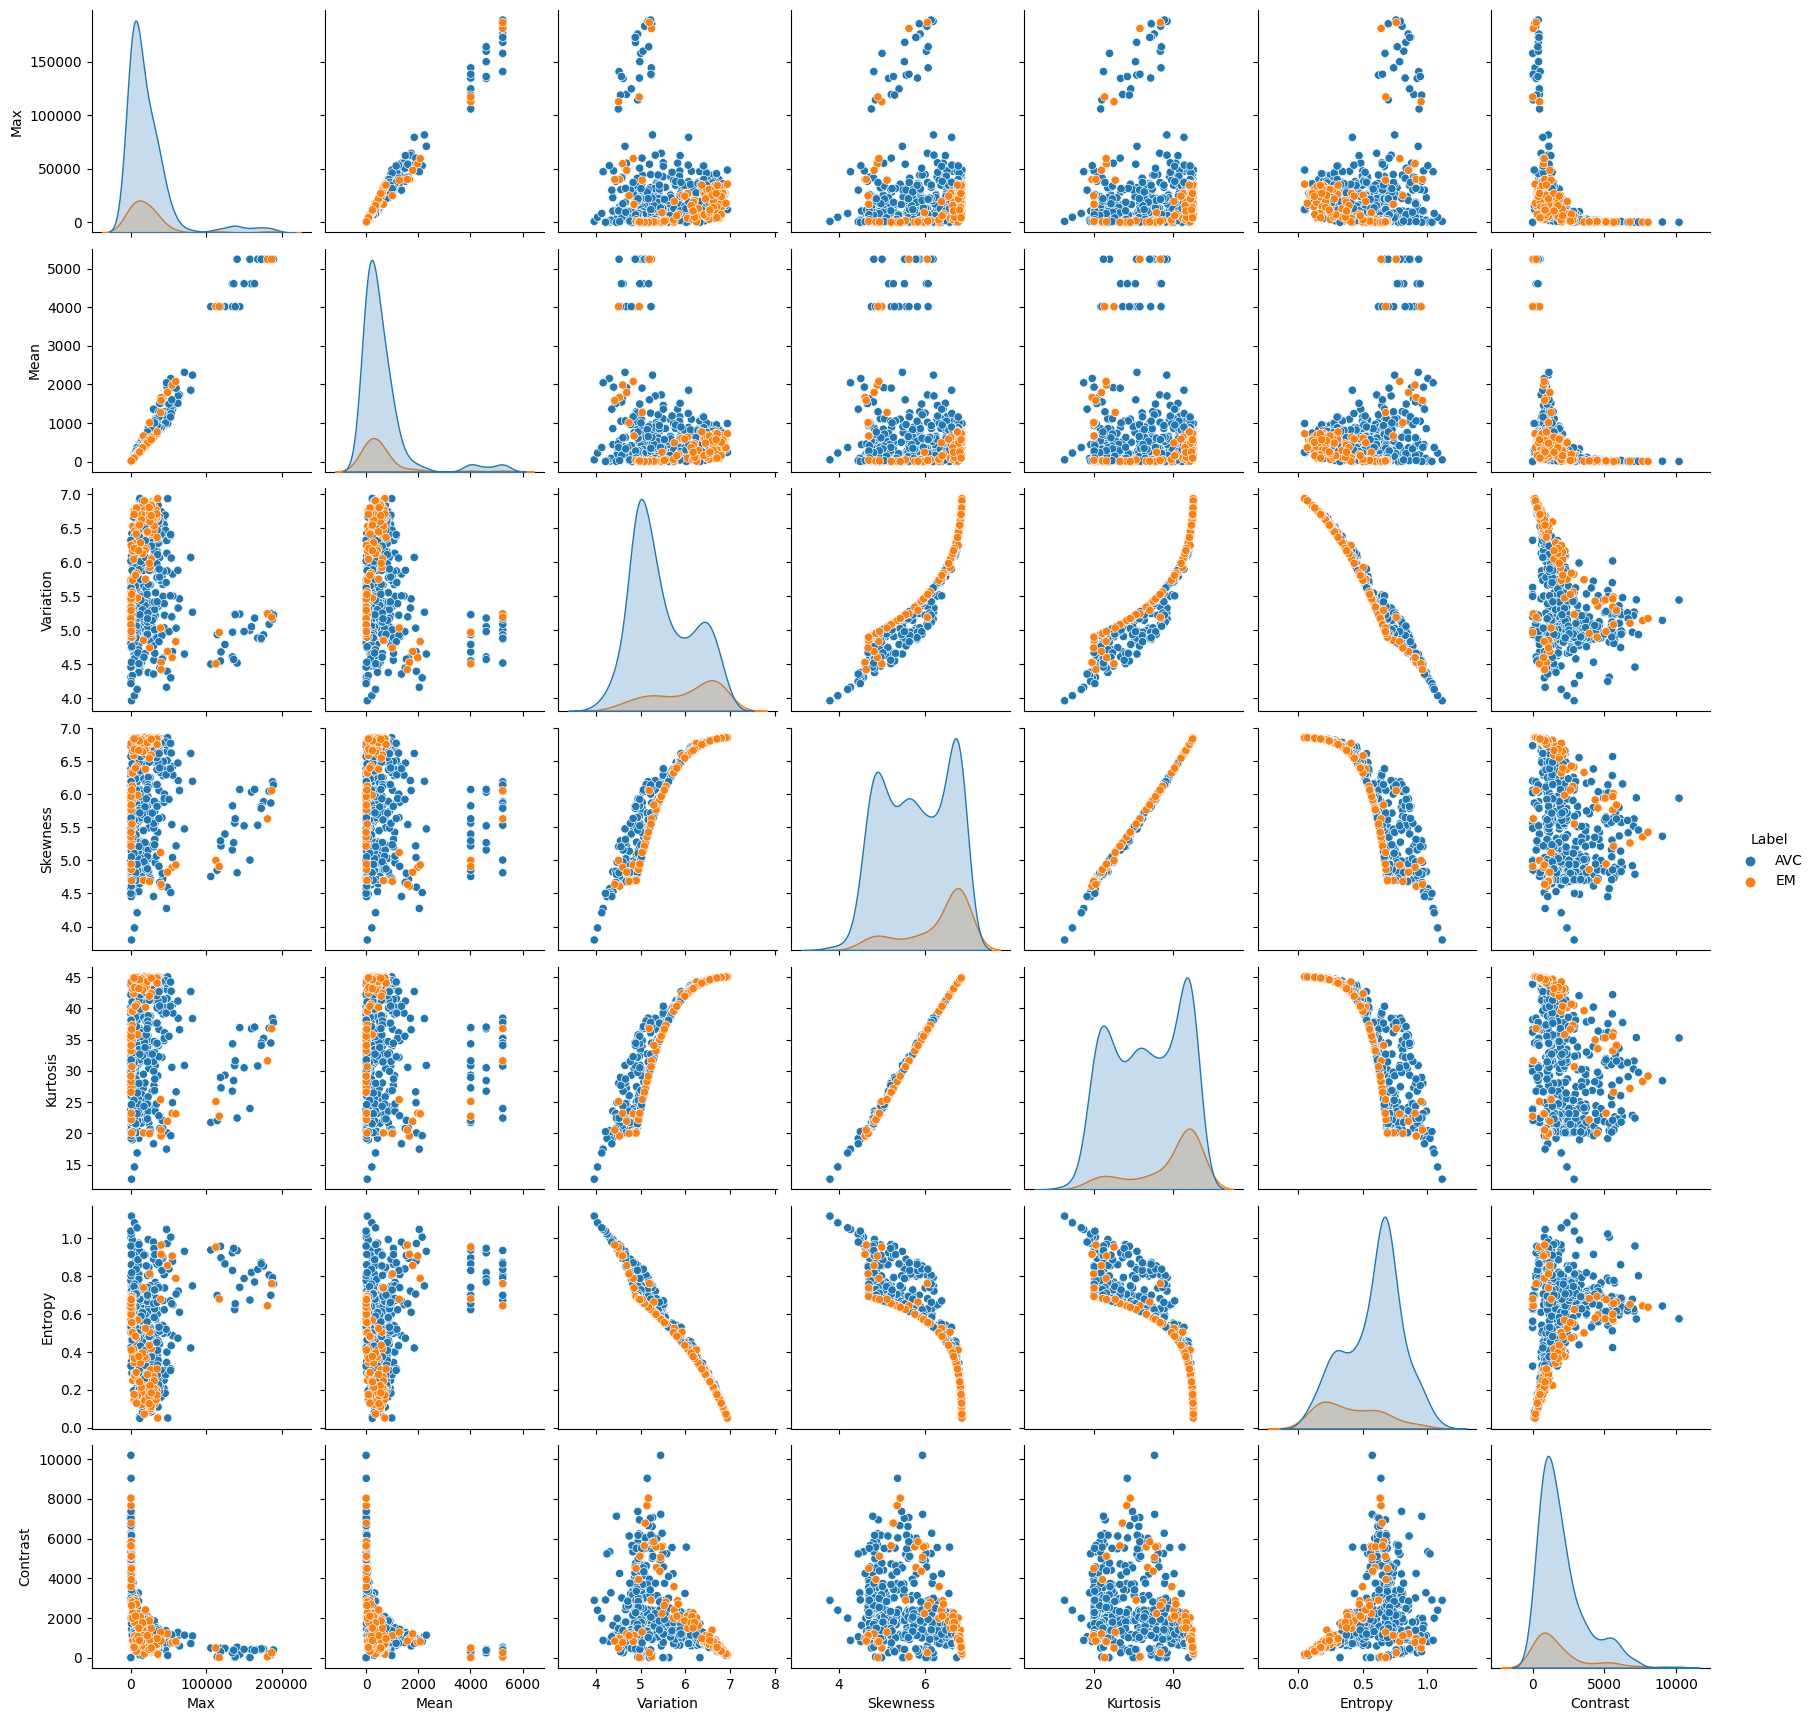

In [161]:
sns.pairplot(df, vars=['Max','Mean','Variation','Skewness','Kurtosis','Entropy','Contrast'], hue='Label')

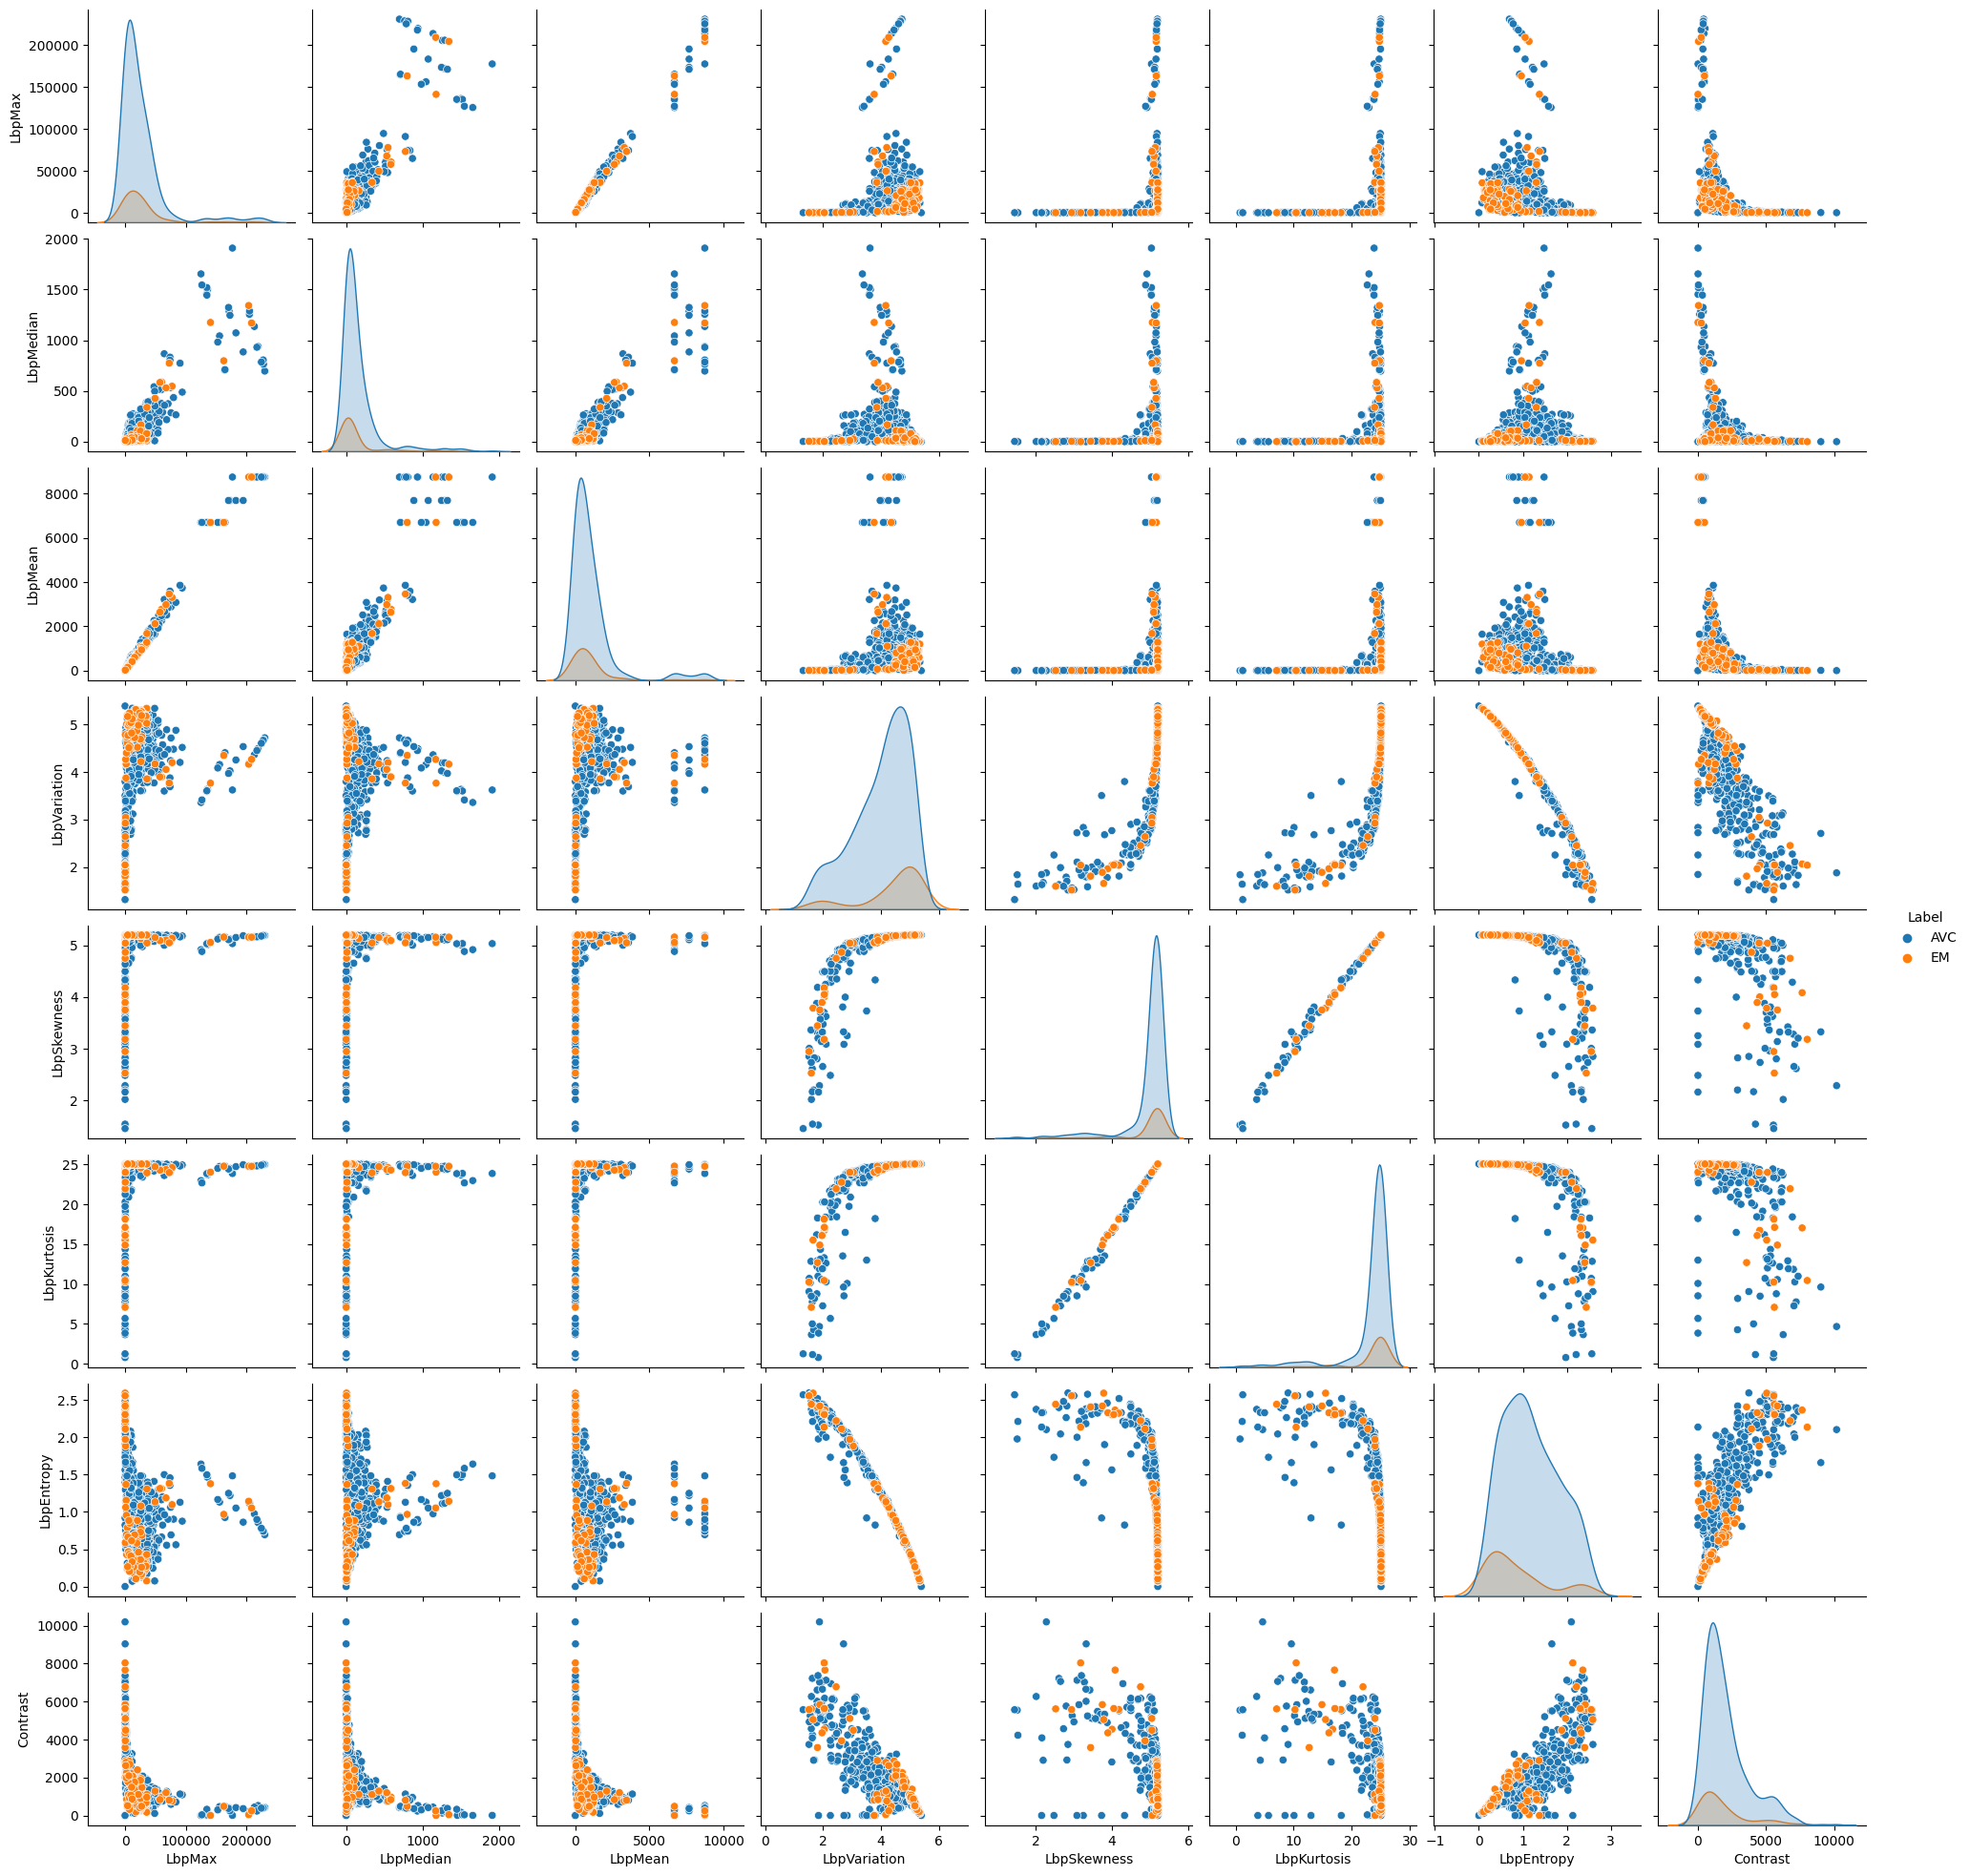

In [162]:
sns.pairplot(df, vars=['LbpMax','LbpMedian', 'LbpMean','LbpVariation','LbpSkewness','LbpKurtosis','LbpEntropy','Contrast'], hue='Label')

In [163]:
# df.to_csv(os.path.join(interim_dir, "attributes.csv"), index=False)
# df = pd.read_csv(os.path.join(interim_dir, "attributes.csv"))

In [164]:
def cross_validate_by_patient(estimator, cv, data, x_vars, y_vars, keep_together_column):
    keep_together_list = data[keep_together_column]
    _, idxs_kt = np.unique(keep_together_list, return_index=True)
    X = data[x_vars]
    y = data[y_vars]
    metrics = {
        'roc_auc':[], 'accuracy':[], 'balanced_accuracy':[], 'estimator':[], 'confusion_matrix': []
    }
    # print(idxs_kt[inverse_ns])
    for (train_idx_kt, val_idx_kt) in cv.split(np.zeros(len(idxs_kt)), y[idxs_kt]):
        # print('split', 0, df.loc[idxs_kt[train_idx_kt], ["Label", "PatientId"]])
        train_idx = np.concatenate([np.argwhere(np.array(keep_together_list) == keep_together) for keep_together in keep_together_list[idxs_kt[train_idx_kt]]]).flatten()
        val_idx = np.concatenate([np.argwhere(np.array(keep_together_list) == keep_together) for keep_together in keep_together_list[idxs_kt[val_idx_kt]]]).flatten()

        # print(train_idx)

        X_train = X.loc[train_idx, :]
        y_train = y.loc[train_idx]
        X_val = X.loc[val_idx, :]
        y_val = y.loc[val_idx]

        new_estimator = copy.deepcopy(estimator)
        new_estimator.fit(X_train, y_train)
        metrics['estimator'].append(new_estimator)
        y_pred = new_estimator.predict(X_val)
        metrics['roc_auc'].append(roc_auc_score(y_val == data[y_vars][0], y_pred == data[y_vars][0]))
        metrics['accuracy'].append(accuracy_score(y_val == data[y_vars][0], y_pred == data[y_vars][0]))
        metrics['balanced_accuracy'].append(balanced_accuracy_score(y_val == data[y_vars][0], y_pred == data[y_vars][0]))
        metrics['confusion_matrix'].append(confusion_matrix(y_val, y_pred))
    return metrics

In [165]:
skf = StratifiedKFold(5)
svc = SVC(kernel='sigmoid', gamma='scale')
lr = LogisticRegression()

metrics = cross_validate_by_patient(estimator=svc, cv=skf, data=df, x_vars=["Entropy", "Contrast"], y_vars='Label', keep_together_column='PatientId')
metrics

{'roc_auc': [0.5340659340659341,
  0.46172248803827753,
  0.6747787610619469,
  0.45128676470588236,
  0.5055445544554455],
 'accuracy': [0.7477477477477478,
  0.7131782945736435,
  0.8211382113821138,
  0.7256637168141593,
  0.7380952380952381],
 'balanced_accuracy': [0.5340659340659341,
  0.46172248803827753,
  0.6747787610619469,
  0.45128676470588236,
  0.5055445544554455],
 'estimator': [SVC(kernel='sigmoid'),
  SVC(kernel='sigmoid'),
  SVC(kernel='sigmoid'),
  SVC(kernel='sigmoid'),
  SVC(kernel='sigmoid')],
 'confusion_matrix': [array([[79, 12],
         [16,  4]]),
  array([[90, 20],
         [17,  2]]),
  array([[96, 17],
         [ 5,  5]]),
  array([[81, 15],
         [16,  1]]),
  array([[90, 11],
         [22,  3]])]}

Text(0.5, 1.0, 'Confusion matrix for the selected SVM classifier')

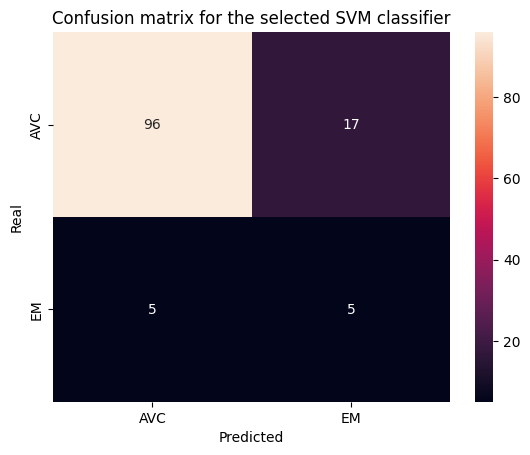

In [166]:
our_estimator_idx = 2

sns.heatmap(metrics['confusion_matrix'][our_estimator_idx], xticklabels=['AVC', 'EM'], yticklabels=['AVC', 'EM'], annot=True)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion matrix for the selected SVM classifier')